In [45]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join as pjoin


import astropy
from astropy.io import fits
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
lhid = 3
wdir = '../data'
source_dir = pjoin(wdir, 'jax1lpt/L3000-N384', str(lhid))

lhpath = pjoin(wdir, 'quijote', 'latin_hypercube_params_bonus.txt')
lh_lookup = pd.read_csv(
    lhpath, delimiter=' ', header=None, 
    names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
print(lh_lookup.iloc[lhid+1])

Omega_m    0.14330
Omega_b    0.06347
h          0.61270
n_s        1.15010
sigma_8    0.76990
Name: 4, dtype: float64


In [55]:
Lbox=3000
rho = np.load(pjoin(source_dir, 'rho.npy'))
hpos = np.load(pjoin(source_dir, 'halo_pos.npy'))
hvel = np.load(pjoin(source_dir, 'halo_vel.npy'))
hmass = np.load(pjoin(source_dir, 'halo_mass.npy'))
hcpos = np.load(pjoin(source_dir, 'halo_cuboid_pos.npy'))
hcvel = np.load(pjoin(source_dir, 'halo_cuboid_vel.npy'))

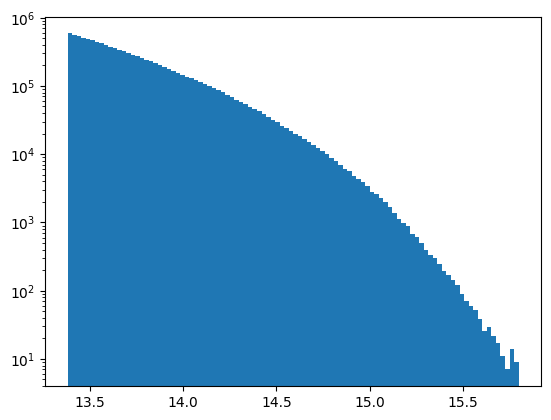

In [56]:
plt.semilogy()
_ = plt.hist(hmass, bins=100)

In [57]:
hvnorm = np.linalg.norm(hcvel, axis=1)

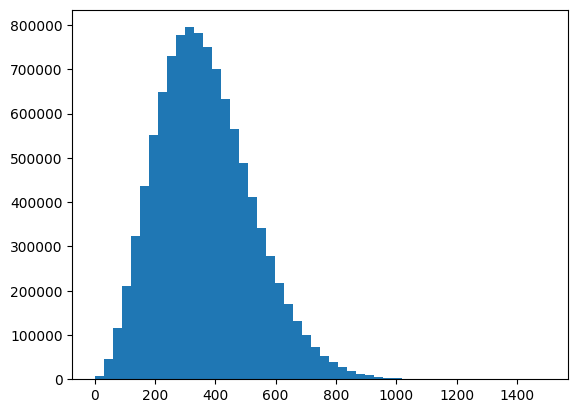

In [58]:
_ = plt.hist(hvnorm, bins=50)

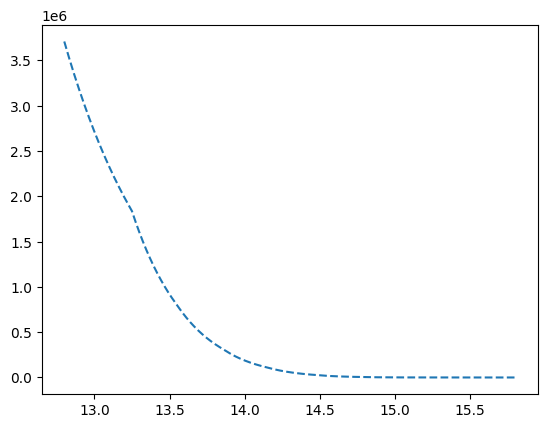

In [41]:
# plt.semilogy()
H, he = np.histogram(hmass, bins=10)
hc = (he[1:] + he[:-1])/2
# plt.plot(hc, H)

x_ = np.linspace(he[0], he[-1], 1000)

itrp = IUS(hc, H, k=1, ext=0)
# plt.plot(x_, itrp(x_), '--')

itrp = IUS(hc, np.log(H), k=1, ext=0)
plt.plot(x_, np.exp(itrp(x_)), '--')

In [42]:
from scipy.integrate import quad
be = np.linspace(he[0], he[-1], 1000)
cdf = [quad(lambda x: np.exp(itrp(x)), be[i], be[i+1])[0] for i in range(len(be)-1)]
cdf = [0] + cdf
cdf = np.cumsum(cdf)
cdf /= cdf[-1]

(0.95, 16.580582372553533)

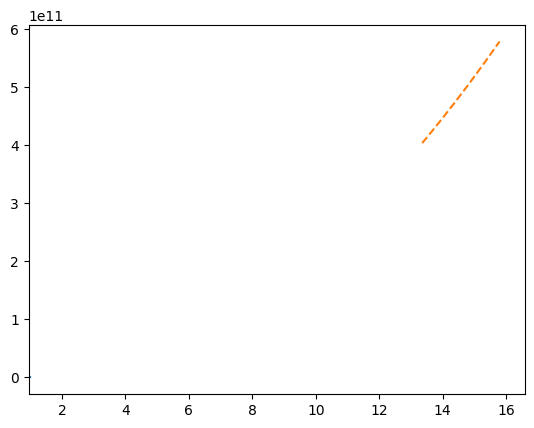

In [25]:
# plt.semilogy()
plt.plot(cdf,be)

interp = IUS(cdf, be, k=2, ext=0)
plt.plot(x_, interp(x_), '--')
plt.xlim(0.95)

In [61]:
interp(cdf)-be

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

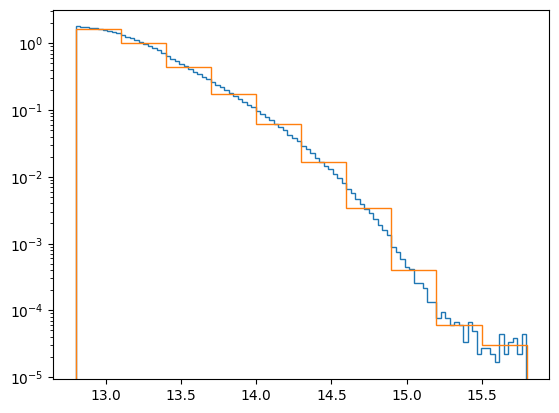

In [44]:
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
def sample_masses(Nsamp, medg):
    """Linearly interpolate between the mass PDF and sample."""
    mcen = (medg[1:] + medg[:-1])/2

    # remove unresolved bins at low/high mass
    mask = np.array(Nsamp) > 0
    l, r = mask.argmax(), mask.size - mask[::-1].argmax()+2
    maskedg, maskcen, maskN = medg[l:r], mcen[l:r], Nsamp[l:r]

    # calculate the mass PDF
    pdf = IUS(maskcen, np.log(maskN), k=2, ext=0)
    be = np.linspace(maskedg[0], maskedg[-1], 1000)
    ipdf = [0] + [quad(lambda x: np.exp(pdf(x)), be[i], be[i+1])[0]
                  for i in range(len(be)-1)]
    cdf = np.cumsum(ipdf)
    cdf /= cdf[-1]
    invcdf = IUS(cdf, be, k=2, ext=3)

    # sample the invcdf
    hmass = []
    empcdf =[0] + [quad(lambda x: np.exp(pdf(x)), medg[i], medg[i+1])[0]
                   for i in range(len(medg)-1)]
    empcdf = np.cumsum(empcdf)
    empcdf /= empcdf[-1]
    for i in range(len(Nsamp)):
        if Nsamp[i] == 0:
            hmass.append([])
            continue
        u = np.random.uniform(low=empcdf[i], high=empcdf[i+1], size=Nsamp[i])
        m = invcdf(u)
        hmass.append(m)
    return hmass
H, he = np.histogram(hmass, bins=10)
m = np.concatenate(sample_masses(H, he))
plt.semilogy()
_ = plt.hist(m, bins=100, histtype='step', density=True)
_ = plt.hist(hmass, bins=10, histtype='step', density=True)

In [84]:
o = np.array([1,2,3,4,5,6,6,6,6])
np.argmax(o==6)

5

In [34]:
H, he = np.histogram(hmass, bins=10)
cumsum = np.array([0.,*np.cumsum(H)/np.sum(H)])
cumsum

array([0.        , 0.48583331, 0.79041795, 0.92123711, 0.97552978,
       0.98761517, 0.99884646, 0.9994834 , 0.99997285, 0.99999106,
       1.        ])

In [19]:
from scipy.interpolate import interp1d

y0 = []
for i in range(len(H)):
    x = np.random.rand(H[i])
    x = (cumsum[i+1] - cumsum[i])*x + cumsum[i]
    y = interp1d(cumsum, he, kind='quadratic')(x)
    y0.append(y)
y0 = np.concatenate(y0)

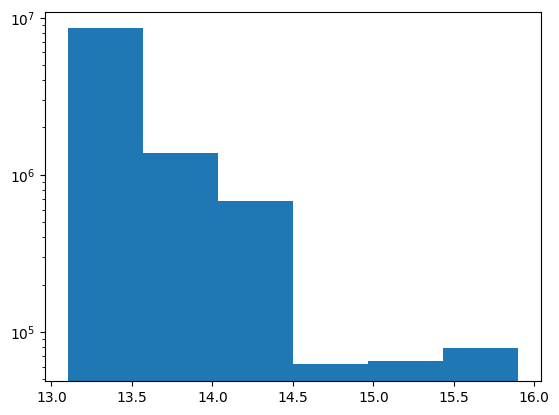

In [25]:
plt.semilogy()
_ = plt.hist(y0, bins=6)

In [105]:
def sample_masses(Nsamp, medges):
    """Linearly interpolate between different mass bins and sample."""

    # calculate the cdf from high-to-low mass
    cdf = np.array([0., *np.cumsum(Nsamp)/np.sum(Nsamp)])
    hmass = []
    for i in range(len(Nsamp)):
        x = np.random.rand(Nsamp[i])
        x = (cdf[i+1] - cdf[i])*x + cdf[i]
        m = interp1d(cdf, medges, kind='quadratic')(x)
        hmass.append(m)
    return hmass

y0 = np.concatenate(sample_masses(H, he))

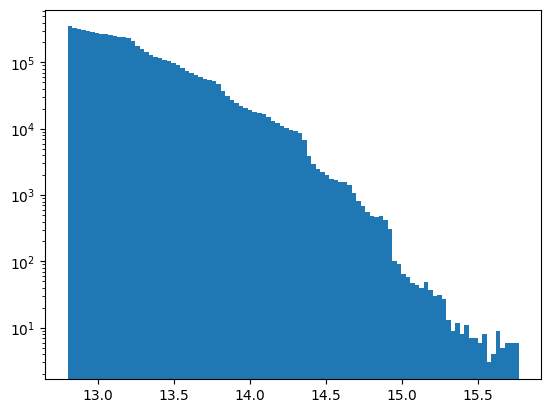

In [106]:
plt.semilogy()
_ = plt.hist(y0, bins=100)